Daniel Khalil: 2205957

Philippe Des Boscs: 2176993

Christina Liu: 2205359

Github link: https://github.com/danielpkhalil/BEM-114

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

Cleaning the data - crsp

In [2]:
stockdf = pd.read_csv('crsp_1926_2020.csv')

shrcds = [10, 11]
exchcds = [1, 2, 3]
shrcd_mask = stockdf['SHRCD'].apply(lambda x: True if x in shrcds else False)
exchcd_mask = stockdf['EXCHCD'].apply(lambda x: True if x in exchcds else False)
stockdf = stockdf[shrcd_mask & exchcd_mask]

stockdf['PRC'] = stockdf['PRC'].apply(lambda x: x if x > 0 else np.nan)
stockdf['RET'] = pd.to_numeric(stockdf['RET'], errors='coerce')
stockdf['date'] = pd.to_datetime(stockdf['date']).dt.to_period('M')
stockdf['year'] = stockdf['date'].dt.year

stockdf

,PERMNO,date,SHRCD,EXCHCD,PRC,RET,SHROUT,year
1,10000,1986-01,10.0,3.0,NaN,NaN,3680.0,1986
2,10000,1986-02,10.0,3.0,NaN,-0.257143,3680.0,1986
3,10000,1986-03,10.0,3.0,NaN,0.365385,3680.0,1986
4,10000,1986-04,10.0,3.0,NaN,-0.098592,3793.0,1986
5,10000,1986-05,10.0,3.0,NaN,-0.222656,3793.0,1986
...,...,...,...,...,...,...,...,...
4705164,93436,2020-08,11.0,3.0,498.32001,0.741452,931809.0,2020
4705165,93436,2020-09,11.0,3.0,429.01001,-0.139087,948000.0,2020
4705166,93436,2020-10,11.0,3.0,388.04001,-0.095499,947901.0,2020
4705167,93436,2020-11,11.0,3.0,567.59998,0.462736,947901.0,2020


In [3]:
listsdf = pd.read_csv('bcwlist.csv')
listsdf = listsdf.rename(columns={'permno': 'PERMNO'})
listsdf = listsdf[listsdf['PERMNO'].isin(stockdf['PERMNO'])]
listsdf['PERMNO'] = listsdf['PERMNO'].astype(int)
listsdf

,rank,company,PERMNO,year
0,1,AT&T Bell Laboratories,66093,1984
1,2,Trammell Crow Company,85629,1984
2,3,Delta Airlines,26112,1984
3,4,Federal Express,60628,1984
4,5,Goldman Sachs,86868,1984
...,...,...,...,...
2483,84,Nutanix,16304,2020
2486,87,AbbVie,13721,2020
2487,88,Encompass Home Health & Hospice,10693,2020
2493,94,Goldman Sachs,86868,2020


In [4]:
filtered_1984_df = listsdf[listsdf['year'] == 1984]

filtered_1993_df = listsdf[listsdf['year'] == 1993]

additional_rows = []
for _, row in filtered_1984_df.iterrows():
    for year in range(1985, 1993):
        additional_rows.append({
            'rank': row['rank'],
            'company': row['company'],
            'PERMNO': row['PERMNO'],
            'year': year
        })
        
for _, row in filtered_1993_df.iterrows():
    for year in range(1994, 1998):
        additional_rows.append({
            'rank': row['rank'],
            'company': row['company'],
            'PERMNO': row['PERMNO'],
            'year': year
        })

listsdf = pd.concat([listsdf, pd.DataFrame(additional_rows)], ignore_index=True).sort_values(by=['year'])
listsdf

,rank,company,PERMNO,year
0,1,AT&T Bell Laboratories,66093,1984
61,101,People Express Airlines,62069,1984
60,101,Olga Company,59425,1984
59,101,Odetics,67029,1984
58,101,Nucor Corporation,34817,1984
...,...,...,...,...
1191,38,Marriott International,85913,2020
1192,42,T-Mobile US,91937,2020
1193,44,Synchrony Financial,14776,2020
1185,20,CarMax,89508,2020


In [5]:
merged = pd.merge(stockdf, listsdf, on=['PERMNO', 'year'], how='inner')
merged['ME'] = (merged['PRC'] * merged['SHROUT'])
merged = merged.drop(['SHRCD', 'EXCHCD', 'PRC', 'SHROUT'], axis=1)
merged

,PERMNO,date,RET,year,rank,company,ME
0,10078,1998-01,0.202194,1998,69,Sun Microsystems,1.809003e+07
1,10078,1998-02,-0.006519,1998,69,Sun Microsystems,1.797210e+07
2,10078,1998-03,-0.124016,1998,69,Sun Microsystems,1.580352e+07
3,10078,1998-04,-0.012734,1998,69,Sun Microsystems,1.560228e+07
4,10078,1998-05,-0.027314,1998,69,Sun Microsystems,1.517612e+07
...,...,...,...,...,...,...,...
23074,93374,2020-08,0.030582,2020,76,First American Financial Corporation,5.862554e+06
23075,93374,2020-09,-0.023207,2020,76,First American Financial Corporation,5.677432e+06
23076,93374,2020-10,-0.124141,2020,76,First American Financial Corporation,4.978251e+06
23077,93374,2020-11,0.086342,2020,76,First American Financial Corporation,5.408084e+06


Create portfolios

In [6]:
def calc_weights(group):
    group['weights_eq'] = 1 / float(group['year'].count())
    group['TME'] = group['ME'].sum()
    group['weights_val'] = group['ME'] / group['TME']
    return group

merged = merged.groupby(['date']).apply(calc_weights)
merged

PERMNO     date       RET  year  rank  \
date                                                   
1984-01 396     10604  1984-01  0.063584  1984   101   
        696     11607  1984-01  0.026786  1984   101   
        876     11703  1984-01 -0.043269  1984   101   
        1044    11754  1984-01 -0.042693  1984   101   
        1152    11850  1984-01  0.063545  1984   101   
...               ...      ...       ...   ...   ...   
2020-12 22383   90215  2020-12 -0.094670  2020     6   
        22785   91926  2020-12 -0.000994  2020    99   
        22821   91937  2020-12  0.014367  2020    42   
        23018   93098  2020-12  0.031680  2020    28   
        23078   93374  2020-12  0.075351  2020    76   

                                            company            ME  weights_eq  \
date                                                                            
1984-01 396              Atlantic Richfield Company  1.130132e+07    0.014085   
        696                        Dana Corporation  1.623886e+06    0.014085   
        876                                 Du Pont  1.188368e+07    0.014085   
        1044                  Eastman Kodak Company  1.207539e+07    0.014085   
        1152                      Exxon Corporation  3.363236e+07    0.014085   
...                                             ...           ...         ...   
2020-12 22383                        Salesforce.com  2.036150e+08    0.029412   
        22785                        Delta Airlines  2.564328e+07    0.029412   
        22821                           T-Mobile US  1.674576e+08    0.029412   
        23018              Hyatt Hotels Corporation  2.905922e+06    0.029412   
        23078  First American Financial Corporation  5.764231e+06    0.029412   

                        TME  weights_val  
date                                      
1984-01 396    2.946056e+08     0.038361  
        696    2.946056e+08     0.005512  
        876    2.946056e+08     0.040338  
        1044   2.946056e+08     0.040988  
        1152   2.946056e+08     0.114161  
...                     ...          ...  
2020-12 22383  2.404586e+09     0.084678  
        22785  2.404586e+09     0.010664  
        22821  2.404586e+09     0.069641  
        23018  2.404586e+09     0.001208  
        23078  2.404586e+09     0.002397  

[23079 rows x 10 columns]

In [7]:
unique_dates = merged['date'].unique()
previous_permnos = None
dates_with_changes = []

for i, date in enumerate(unique_dates):
    date_group = merged[merged['date'] == date]

    current_permnos = set(date_group['PERMNO'])

    if previous_permnos is not None:
        if current_permnos != previous_permnos:
            dates_with_changes.append(date)

    previous_permnos = current_permnos

print("Dates with changes in PERMNO:")
print(dates_with_changes)


Dates with changes in PERMNO:
[Period('1984-02', 'M'), Period('1984-07', 'M'), Period('1984-11', 'M'), Period('1984-12', 'M'), Period('1985-10', 'M'), Period('1986-01', 'M'), Period('1986-07', 'M'), Period('1987-01', 'M'), Period('1987-04', 'M'), Period('1987-10', 'M'), Period('1988-04', 'M'), Period('1988-11', 'M'), Period('1990-02', 'M'), Period('1991-07', 'M'), Period('1992-05', 'M'), Period('1993-01', 'M'), Period('1993-09', 'M'), Period('1995-06', 'M'), Period('1995-08', 'M'), Period('1995-10', 'M'), Period('1995-12', 'M'), Period('1996-08', 'M'), Period('1997-06', 'M'), Period('1997-10', 'M'), Period('1998-01', 'M'), Period('1998-02', 'M'), Period('1998-03', 'M'), Period('1999-01', 'M'), Period('1999-05', 'M'), Period('1999-07', 'M'), Period('1999-08', 'M'), Period('2000-01', 'M'), Period('2000-06', 'M'), Period('2001-01', 'M'), Period('2002-01', 'M'), Period('2002-05', 'M'), Period('2002-07', 'M'), Period('2003-01', 'M'), Period('2004-01', 'M'), Period('2005-01', 'M'), Period('2

We now want to update the refactoring of the weights to only take place on XXXX-01 which corresponds to our investment on February 1st as the list of Best companies gets updated (on the years that it does get updated) and to handle stocks that might IPO (become listed) or delist

In [8]:

def recalculate_weights(group):
    # Equal weighting
    group['weights_eq'] = 1 / len(group)
    # Total market equity
    group['TME'] = group['ME'].sum()
    # Value weighting
    group['weights_val'] = group['ME'] / group['TME']
    return group

weights_dict = {}

for date in merged['date'].unique():
    # If the date is a change date, recalculate weights
    if date in dates_with_changes:
        # Recalculate weights for the date
        group = merged[merged['date'] == date].copy()
        recalculated_group = recalculate_weights(group)
        
        # Update the dictionary with recalculated weights for each PERMNO
        for _, row in recalculated_group.iterrows():
            weights_dict[row['PERMNO']] = {
                'weights_eq': row['weights_eq'],
                'weights_val': row['weights_val']
            }

        # Update the DataFrame with new weights
        merged.loc[merged['date'] == date, ['weights_eq', 'weights_val']] = recalculated_group[['weights_eq', 'weights_val']]
    else:
        # If not a change date, set weights from the dictionary
        for _, row in merged[merged['date'] == date].iterrows():
            if row['PERMNO'] in weights_dict:
                merged.loc[row.name, 'weights_eq'] = weights_dict[row['PERMNO']]['weights_eq']
                merged.loc[row.name, 'weights_val'] = weights_dict[row['PERMNO']]['weights_val']

print("Updated Portfolio with Correct Weights:")
merged

Updated Portfolio with Correct Weights:


PERMNO     date       RET  year  rank  \
date                                                   
1984-01 396     10604  1984-01  0.063584  1984   101   
        696     11607  1984-01  0.026786  1984   101   
        876     11703  1984-01 -0.043269  1984   101   
        1044    11754  1984-01 -0.042693  1984   101   
        1152    11850  1984-01  0.063545  1984   101   
...               ...      ...       ...   ...   ...   
2020-12 22383   90215  2020-12 -0.094670  2020     6   
        22785   91926  2020-12 -0.000994  2020    99   
        22821   91937  2020-12  0.014367  2020    42   
        23018   93098  2020-12  0.031680  2020    28   
        23078   93374  2020-12  0.075351  2020    76   

                                            company            ME  weights_eq  \
date                                                                            
1984-01 396              Atlantic Richfield Company  1.130132e+07    0.014085   
        696                        Dana Corporation  1.623886e+06    0.014085   
        876                                 Du Pont  1.188368e+07    0.014085   
        1044                  Eastman Kodak Company  1.207539e+07    0.014085   
        1152                      Exxon Corporation  3.363236e+07    0.014085   
...                                             ...           ...         ...   
2020-12 22383                        Salesforce.com  2.036150e+08    0.029412   
        22785                        Delta Airlines  2.564328e+07    0.029412   
        22821                           T-Mobile US  1.674576e+08    0.029412   
        23018              Hyatt Hotels Corporation  2.905922e+06    0.029412   
        23078  First American Financial Corporation  5.764231e+06    0.029412   

                        TME  weights_val  
date                                      
1984-01 396    2.946056e+08     0.038361  
        696    2.946056e+08     0.005512  
        876    2.946056e+08     0.040338  
        1044   2.946056e+08     0.040988  
        1152   2.946056e+08     0.114161  
...                     ...          ...  
2020-12 22383  2.404586e+09     0.085811  
        22785  2.404586e+09     0.019130  
        22821  2.404586e+09     0.036010  
        23018  2.404586e+09     0.001641  
        23078  2.404586e+09     0.003695  

[23079 rows x 10 columns]

In [9]:
def calculate_weighted_returns_manual(dataframe):

    dataframe['weighted_val_ret'] = 0
    dataframe['weighted_eq_ret'] = 0

    unique_dates = dataframe['date'].unique()

    for i, date in enumerate(unique_dates):
        if i == 0:
            continue

        prev_date = unique_dates[i - 1]

        current_permn = dataframe[dataframe['date'] == date]['PERMNO']
        prev_weights = dataframe[dataframe['date'] == prev_date][['PERMNO', 'weights_val', 'weights_eq']]

        for permno in current_permn:
            weight_data = prev_weights[prev_weights['PERMNO'] == permno]

            if not weight_data.empty:
                ret = dataframe[(dataframe['PERMNO'] == permno) & (dataframe['date'] == date)]['RET'].values[0]

                val_weight = weight_data['weights_val'].values[0]
                eq_weight = weight_data['weights_eq'].values[0]

            dataframe.loc[(dataframe['PERMNO'] == permno) & (dataframe['date'] == date), 'weighted_val_ret'] = val_weight * ret * 100
            dataframe.loc[(dataframe['PERMNO'] == permno) & (dataframe['date'] == date), 'weighted_eq_ret'] = eq_weight * ret * 100

    return dataframe


final_df = calculate_weighted_returns_manual(merged)
final_df

C:\Users\danie\AppData\Local\Temp\ipykernel_24636\5882450.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-0.02119437387947965' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataframe.loc[(dataframe['PERMNO'] == permno) & (dataframe['date'] == date), 'weighted_val_ret'] = val_weight * ret * 100
C:\Users\danie\AppData\Local\Temp\ipykernel_24636\5882450.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-0.007781690140845071' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataframe.loc[(dataframe['PERMNO'] == permno) & (dataframe['date'] == date), 'weighted_eq_ret'] = eq_weight * ret * 100


PERMNO     date       RET  year  rank  \
date                                                   
1984-01 396     10604  1984-01  0.063584  1984   101   
        696     11607  1984-01  0.026786  1984   101   
        876     11703  1984-01 -0.043269  1984   101   
        1044    11754  1984-01 -0.042693  1984   101   
        1152    11850  1984-01  0.063545  1984   101   
...               ...      ...       ...   ...   ...   
2020-12 22383   90215  2020-12 -0.094670  2020     6   
        22785   91926  2020-12 -0.000994  2020    99   
        22821   91937  2020-12  0.014367  2020    42   
        23018   93098  2020-12  0.031680  2020    28   
        23078   93374  2020-12  0.075351  2020    76   

                                            company            ME  weights_eq  \
date                                                                            
1984-01 396              Atlantic Richfield Company  1.130132e+07    0.014085   
        696                        Dana Corporation  1.623886e+06    0.014085   
        876                                 Du Pont  1.188368e+07    0.014085   
        1044                  Eastman Kodak Company  1.207539e+07    0.014085   
        1152                      Exxon Corporation  3.363236e+07    0.014085   
...                                             ...           ...         ...   
2020-12 22383                        Salesforce.com  2.036150e+08    0.029412   
        22785                        Delta Airlines  2.564328e+07    0.029412   
        22821                           T-Mobile US  1.674576e+08    0.029412   
        23018              Hyatt Hotels Corporation  2.905922e+06    0.029412   
        23078  First American Financial Corporation  5.764231e+06    0.029412   

                        TME  weights_val  weighted_val_ret  weighted_eq_ret  
date                                                                         
1984-01 396    2.946056e+08     0.038361          0.000000         0.000000  
        696    2.946056e+08     0.005512          0.000000         0.000000  
        876    2.946056e+08     0.040338          0.000000         0.000000  
        1044   2.946056e+08     0.040988          0.000000         0.000000  
        1152   2.946056e+08     0.114161          0.000000         0.000000  
...                     ...          ...               ...              ...  
2020-12 22383  2.404586e+09     0.085811         -0.812377        -0.278441  
        22785  2.404586e+09     0.019130         -0.001901        -0.002924  
        22821  2.404586e+09     0.036010          0.051736         0.042256  
        23018  2.404586e+09     0.001641          0.005199         0.093176  
        23078  2.404586e+09     0.003695          0.027840         0.221621  

[23079 rows x 12 columns]

In the formation of our portfolios based on the list of Best Companies rankings, we consider the January data to form our portfolios on February 1st. To begin, we cleaned the crsp_1926_2020.cs data in a similar way that we cleaned it in Problem Set 2. We then filled in the data for our Best Companies csv file by copying the rankings from 1984 to each year from 1985 to 1992, inclusive. This allows for us to then merge our crsp data and list of best companies together based on year and PERMNO.

Once we obtain our larger dataset, we group it by date and for each month calculate the weights of each company in the equally weighted portfolio and the value weighted portfolio. We also calculate the market value of each company to then sum them up and divide each company's market value by the total one. For the equally weighted portfolio, each weight corresponds to 1 divided by the number of companies actively publicly listed and on the list of Best Companies. 

To take into account the need to refactor our portfolios in case that a company IPOs or that the stock disappears, we seek to identify the "dates of change" in the companies present in our dataset. For that, we iterate over the sorted unique dates from our dataset and for each of them, we make a set of the PERMNOs of the companies listed. Comparing the set between every two consecutive months, we register the dates for which at least one company has been added or removed from that set qualifying them as "dates of change". Finally, starting from February 1984 to 2020. we iterate over the dates month by month and if the date is in the dates of change, we recalculate the weights, set them for that specific month and keep them in a dictionary. Until the following date of change, we use the weights stored in our dicitionary to "hold our position". We verified manually that this strategy made all January data refactor the weights for when we invest on February 1st.

The caculation of the returns under the structure of our portfolios was slightly more advanced. Since we use the data of January to make our porfolios for February 1st, February's returns must be the RET from that month multiplied by the weights that we used to invest in January. Most generally, the returns of a certain month are calculated using the weights from the previous month (current position) and the RET from the current month. As such, by iterating through all companies and dates, we can calculate their monthly return by fetching the weights of the previous month for the same PERMNO. We also make sure that if a company did not exist the previous month then we should set the return for 0 as it means that this row represents the first appearance of the company on the market, meaning we are starting to invest in it. Similarly all the returns from 1984 January 1st are of 0 as we start to invest and do not yet perceive returns. Since we get rid of the January data for companies that we previously invested in after refactoring for our February 1st investment, we fetch the return for those companies directly from the crsp dataset ensuring that we are multiplying the weights from the previous month with the returns they had in the January data.

The current layout of our portfolio can then be used to make the specific portfolios metioned in the paper over multiple years or year by year just by filtering by the correct dates.

Question 2

Part a

In [10]:
merged.reset_index(drop = True, inplace = True)
# Sum up portfolio returns
eqports = merged.groupby(['date'])['weighted_eq_ret'].sum()
# Missing accounting data in early years
eqports = eqports.dropna()
# Match data format of FF factors
eqports = eqports
eqports = eqports.reset_index()
eqports.set_index('date', inplace=True)

valports = merged.groupby(['date'])['weighted_val_ret'].sum()
valports = valports.dropna()
valports = valports
valports = valports.reset_index()
valports.set_index('date', inplace=True)

mean_monthly_returns_eq = eqports.mean(axis=0)
mean_monthly_returns_val = valports.mean(axis=0)

volatility_eq = eqports.std()
volatility_val = valports.std()

sharpe_ratio_eq = mean_monthly_returns_eq / volatility_eq
sharpe_ratio_val = mean_monthly_returns_val / volatility_val

print(f"Equal-Weighted Portfolio:")
print(f"Average Monthly Return: {mean_monthly_returns_eq}")
print(f"Volatility: {volatility_eq}")
print(f"Sharpe Ratio: {sharpe_ratio_eq}\n")

print(f"Value-Weighted Portfolio:")
print(f"Average Monthly Return: {mean_monthly_returns_val}")
print(f"Volatility: {volatility_val}")
print(f"Sharpe Ratio: {sharpe_ratio_val}\n")

valports

Equal-Weighted Portfolio:
Average Monthly Return: weighted_eq_ret    1.226056
dtype: float64
Volatility: weighted_eq_ret    5.434177
dtype: float64
Sharpe Ratio: weighted_eq_ret    0.225619
dtype: float64

Value-Weighted Portfolio:
Average Monthly Return: weighted_val_ret    1.119299
dtype: float64
Volatility: weighted_val_ret    5.399984
dtype: float64
Sharpe Ratio: weighted_val_ret    0.207278
dtype: float64



,weighted_val_ret
date,
1984-01,0.000000
1984-02,-4.287976
1984-03,1.339836
1984-04,2.212503
1984-05,-4.581957
...,...
2020-08,10.619510
2020-09,-4.191724
2020-10,-4.480800


In [11]:
eqports.reset_index(inplace=True)
eqports['date'] = eqports['date'].dt.strftime('%Y%m').astype(int)
valports.reset_index(inplace=True)
valports['date'] = valports['date'].dt.strftime('%Y%m').astype(int)

Part b

In [12]:
ff3 = pd.read_csv('ff3_factors.csv')
ff5 = pd.read_csv('ff5_factors.csv')
#make Date into date
ff3.rename(columns={'Date': 'date'}, inplace=True)
ff5.rename(columns={'Date': 'date'}, inplace=True)
ff3_merged_eq = pd.merge(eqports, ff3, on='date')
ff3_merged_val = pd.merge(valports, ff3, on='date')
ff5_merged_eq = pd.merge(eqports, ff5, on='date')
ff5_merged_val = pd.merge(valports, ff5, on='date')

momentum_factor = pd.read_csv('ff_momentum.csv')

ff3_momentum_eq = pd.merge(ff3_merged_eq, momentum_factor, on='date')
ff3_momentum_val = pd.merge(ff3_merged_val, momentum_factor, on='date')

# Estimate CAPM - equally weighted
model1=sm.OLS(ff3_merged_eq['weighted_eq_ret']-ff3_merged_eq['RF'],
              sm.add_constant(ff3_merged_eq[['Mkt-RF']])).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     3695.
Date:                Mon, 29 Apr 2024   Prob (F-statistic):          9.21e-217
Time:                        03:22:48   Log-Likelihood:                -885.62
No. Observations:                 444   AIC:                             1775.
Df Residuals:                     442   BIC:                             1783.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1120      0.086      1.306      0.1

In [13]:
# Estimate CAPM - value weighted
model1=sm.OLS(ff3_merged_val['weighted_val_ret']-ff3_merged_val['RF'],
              sm.add_constant(ff3_merged_val[['Mkt-RF']])).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                     1806.
Date:                Mon, 29 Apr 2024   Prob (F-statistic):          3.39e-158
Time:                        03:22:48   Log-Likelihood:                -1017.4
No. Observations:                 444   AIC:                             2039.
Df Residuals:                     442   BIC:                             2047.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0548      0.115      0.475      0.6

In [14]:
# Estimate FF3 - equally weighted
model1=sm.OLS(ff3_merged_eq['weighted_eq_ret']-ff3_merged_eq['RF'],
              sm.add_constant(ff3_merged_eq[['Mkt-RF', 'SMB', 'HML']])).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     1334.
Date:                Mon, 29 Apr 2024   Prob (F-statistic):          1.96e-220
Time:                        03:22:48   Log-Likelihood:                -868.79
No. Observations:                 444   AIC:                             1746.
Df Residuals:                     440   BIC:                             1762.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1134      0.083      1.368      0.1

In [15]:
# Estimate FF3 - value weighted
model1=sm.OLS(ff3_merged_val['weighted_val_ret']-ff3_merged_val['RF'],
              sm.add_constant(ff3_merged_val[['Mkt-RF', 'SMB', 'HML']])).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     684.2
Date:                Mon, 29 Apr 2024   Prob (F-statistic):          2.98e-165
Time:                        03:22:48   Log-Likelihood:                -993.40
No. Observations:                 444   AIC:                             1995.
Df Residuals:                     440   BIC:                             2011.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0953      0.110      0.869      0.3

In [16]:
# Estimate Carhart - equally weighted
model1=sm.OLS(ff3_momentum_eq['weighted_eq_ret']-ff3_momentum_eq['RF'],
              sm.add_constant(ff3_momentum_eq[['Mkt-RF', 'SMB', 'HML', 'Mom']])).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     1138.
Date:                Mon, 29 Apr 2024   Prob (F-statistic):          3.79e-230
Time:                        03:22:48   Log-Likelihood:                -842.44
No. Observations:                 444   AIC:                             1695.
Df Residuals:                     439   BIC:                             1715.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2157      0.079      2.717      0.0

In [17]:
# Estimate Carhart - value weighted
model1=sm.OLS(ff3_momentum_val['weighted_val_ret']-ff3_momentum_val['RF'],
              sm.add_constant(ff3_momentum_val[['Mkt-RF', 'SMB', 'HML', 'Mom']])).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     561.9
Date:                Mon, 29 Apr 2024   Prob (F-statistic):          3.81e-171
Time:                        03:22:48   Log-Likelihood:                -976.28
No. Observations:                 444   AIC:                             1963.
Df Residuals:                     439   BIC:                             1983.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2057      0.107      1.916      0.0

In [18]:
# Estimate FF5 - equally weighted
model1=sm.OLS(ff5_merged_eq['weighted_eq_ret']-ff5_merged_eq['RF'],
              sm.add_constant(ff5_merged_eq[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']])).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     849.8
Date:                Mon, 29 Apr 2024   Prob (F-statistic):          7.60e-223
Time:                        03:22:48   Log-Likelihood:                -855.86
No. Observations:                 444   AIC:                             1724.
Df Residuals:                     438   BIC:                             1748.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1190      0.084      1.416      0.1

In [19]:
# Estimate FF5 - value weighted
model1=sm.OLS(ff5_merged_val['weighted_val_ret']-ff5_merged_val['RF'],
              sm.add_constant(ff5_merged_val[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']])).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     450.1
Date:                Mon, 29 Apr 2024   Prob (F-statistic):          4.94e-170
Time:                        03:22:48   Log-Likelihood:                -975.60
No. Observations:                 444   AIC:                             1963.
Df Residuals:                     438   BIC:                             1988.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2354      0.110      2.140      0.0

From estimating the CAPM, FF3, Carhart, and FF5 models for both equal- and value-weighted portfolios, we can see that this strategy produces positive and significant alpha.

Part c

In [20]:
ff3_merged_val

,date,weighted_val_ret,Mkt-RF,SMB,HML,RF
0,198401,0.000000,-1.92,-0.38,7.58,0.76
1,198402,-4.287976,-4.82,-1.69,3.33,0.71
2,198403,1.339836,0.63,0.07,0.46,0.73
3,198404,2.212503,-0.51,-1.16,1.20,0.81
4,198405,-4.581957,-5.97,0.06,0.31,0.78
...,...,...,...,...,...,...
439,202008,10.619510,7.63,-0.22,-2.96,0.01
440,202009,-4.191724,-3.63,0.04,-2.68,0.01
441,202010,-4.480800,-2.10,4.37,4.22,0.01
442,202011,15.642394,12.47,5.81,2.13,0.01


C:\Users\danie\AppData\Local\Temp\ipykernel_24636\985842555.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = model1.params[0]
C:\Users\danie\AppData\Local\Temp\ipykernel_24636\985842555.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model1.params[1]


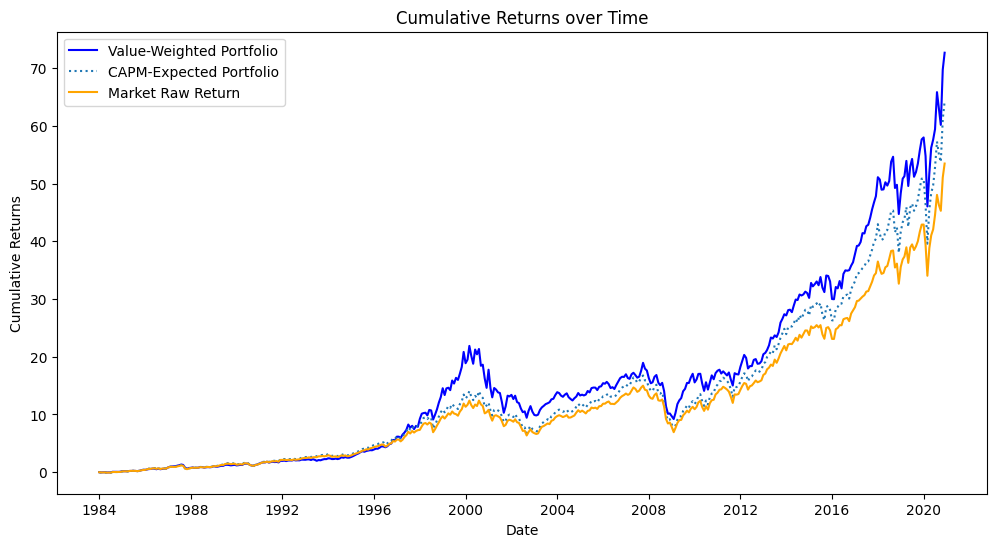

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import pandas as pd

# Fit the CAPM model using excess returns
model1 = sm.OLS(ff3_merged_val['weighted_val_ret']-ff3_merged_val['RF'], sm.add_constant(ff3_merged_val[['Mkt-RF']])).fit()
alpha = model1.params[0]
beta = model1.params[1]

# Convert 'date' column to datetime format
ff3_merged_val['date'] = pd.to_datetime(ff3_merged_val['date'], format='%Y%m')

# Convert percentage returns to decimal format
ff3_merged_val['weighted_val_ret'] = ff3_merged_val['weighted_val_ret'] / 100
ff3_merged_val['Mkt-RF'] = ff3_merged_val['Mkt-RF'] / 100
ff3_merged_val['RF'] = ff3_merged_val['RF'] / 100

# Calculate cumulative returns for the value-weighted portfolio
ff3_merged_val['cumulative_val_ret'] = (1 + ff3_merged_val['weighted_val_ret']).cumprod() - 1

# Calculate expected excess returns
ff3_merged_val['expected_excess_ret'] = beta*ff3_merged_val['Mkt-RF'] + ff3_merged_val['RF']

# Calculate cumulative returns for the expected portfolio
ff3_merged_val['cumulative_expected_ret'] = (1 + ff3_merged_val['expected_excess_ret']).cumprod() - 1

# Calculate market raw return by adding RF to Mkt-RF
ff3_merged_val['market_raw_ret'] = ff3_merged_val['Mkt-RF'] + ff3_merged_val['RF']
ff3_merged_val['cumulative_market_raw_ret'] = (1 + ff3_merged_val['market_raw_ret']).cumprod() - 1

# Plot the cumulative returns
plt.figure(figsize=(12,6))
plt.plot(ff3_merged_val['date'], ff3_merged_val['cumulative_val_ret'], color='blue', label='Value-Weighted Portfolio')
plt.plot(ff3_merged_val['date'], ff3_merged_val['cumulative_expected_ret'], linestyle='dotted', label='CAPM-Expected Portfolio')
plt.plot(ff3_merged_val['date'], ff3_merged_val['cumulative_market_raw_ret'], color='orange', label='Market Raw Return')
plt.legend()
plt.title('Cumulative Returns over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.show()


From the graph, we can see that the actual returns of the value-weighted portfolio are consistently higher than the CAPM-implied expected returns. The large difference between actual and implied returns is likely due to the simplicity of the CAPM model, as it is based on a set of assumptions (for example, perfect market efficiency) that are not necessarily true in reality.

Part d 

In [22]:
# convert back to percent
ff3_merged_val['date'] = ff3_merged_val['date'].dt.strftime('%Y%m')
ff3_merged_val['weighted_val_ret'] = ff3_merged_val['weighted_val_ret'] * 100
ff3_merged_val['Mkt-RF'] = ff3_merged_val['Mkt-RF'] * 100
ff3_merged_val['RF'] = ff3_merged_val['RF'] * 100

In [23]:
# Divide the data into pre- and post- January 1st, 2010 subsamples
pre_period_eq = ff3_momentum_eq[ff3_momentum_eq['date'] < 201001]
post_period_eq = ff3_momentum_eq[ff3_momentum_eq['date'] >= 201001]

model_pre_eq = sm.OLS(pre_period_eq['weighted_eq_ret']-pre_period_eq['RF'], sm.add_constant(pre_period_eq[['Mkt-RF', 'SMB', 'HML', 'Mom']])).fit()
print("Pre-period Equally-Weighted Portfolio:\n", model_pre_eq.summary())


Pre-period Equally-Weighted Portfolio:
                             OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                     895.9
Date:                Mon, 29 Apr 2024   Prob (F-statistic):          7.28e-168
Time:                        03:22:48   Log-Likelihood:                -579.50
No. Observations:                 312   AIC:                             1169.
Df Residuals:                     307   BIC:                             1188.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       

In [24]:
model_post_eq = sm.OLS(post_period_eq['weighted_eq_ret']-post_period_eq['RF'], sm.add_constant(post_period_eq[['Mkt-RF', 'SMB', 'HML', 'Mom']])).fit()
print("\nPost-period Equally-Weighted Portfolio:\n", model_post_eq.summary())


Post-period Equally-Weighted Portfolio:
                             OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     273.4
Date:                Mon, 29 Apr 2024   Prob (F-statistic):           2.28e-61
Time:                        03:22:48   Log-Likelihood:                -256.47
No. Observations:                 132   AIC:                             522.9
Df Residuals:                     127   BIC:                             537.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const     

In [25]:
pre_period_val = ff3_momentum_val[ff3_momentum_val['date'] < 201001]
post_period_val = ff3_momentum_val[ff3_momentum_val['date'] >= 201001]

model_pre_val = sm.OLS(pre_period_val['weighted_val_ret']-pre_period_val['RF'], sm.add_constant(pre_period_val[['Mkt-RF', 'SMB', 'HML', 'Mom']])).fit()
print("\nPre-period Value-Weighted Portfolio:\n", model_pre_val.summary())


Pre-period Value-Weighted Portfolio:
                             OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     385.0
Date:                Mon, 29 Apr 2024   Prob (F-statistic):          3.07e-118
Time:                        03:22:48   Log-Likelihood:                -698.42
No. Observations:                 312   AIC:                             1407.
Df Residuals:                     307   BIC:                             1426.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        

In [26]:
model_post_val = sm.OLS(post_period_val['weighted_val_ret']-post_period_val['RF'], sm.add_constant(post_period_val[['Mkt-RF', 'SMB', 'HML', 'Mom']])).fit()
print("\nPost-period Value-Weighted Portfolio:\n", model_post_val.summary())


Post-period Value-Weighted Portfolio:
                             OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                     225.8
Date:                Mon, 29 Apr 2024   Prob (F-statistic):           1.07e-56
Time:                        03:22:48   Log-Likelihood:                -260.40
No. Observations:                 132   AIC:                             530.8
Df Residuals:                     127   BIC:                             545.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       

Comparison with (Edmans 2011) Table 4 date range

In [27]:
# use same dates as Table 4
table_period_eq = ff3_momentum_eq[ff3_momentum_eq['date'] <= 200912]
table_period_eq = table_period_eq[table_period_eq['date'] >= 199801]

model_pre_eq = sm.OLS(table_period_eq['weighted_eq_ret']-table_period_eq['RF'], sm.add_constant(table_period_eq[['Mkt-RF', 'SMB', 'HML', 'Mom']])).fit()
print("\nPre-period Value-Weighted Portfolio:\n", model_pre_val.summary())


Pre-period Value-Weighted Portfolio:
                             OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     385.0
Date:                Mon, 29 Apr 2024   Prob (F-statistic):          3.07e-118
Time:                        03:22:48   Log-Likelihood:                -698.42
No. Observations:                 312   AIC:                             1407.
Df Residuals:                     307   BIC:                             1426.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        

In [28]:
table_period_val = ff3_momentum_val[ff3_momentum_val['date'] <= 200912]
table_period_val = table_period_val[table_period_val['date'] >= 199801]

model_pre_val = sm.OLS(table_period_val['weighted_val_ret']-table_period_val['RF'], sm.add_constant(table_period_val[['Mkt-RF', 'SMB', 'HML', 'Mom']])).fit()
print("\nPre-period Value-Weighted Portfolio:\n", model_pre_val.summary())


Pre-period Value-Weighted Portfolio:
                             OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     164.3
Date:                Mon, 29 Apr 2024   Prob (F-statistic):           1.22e-51
Time:                        03:22:48   Log-Likelihood:                -350.84
No. Observations:                 144   AIC:                             711.7
Df Residuals:                     139   BIC:                             726.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        

We can see from the regression results that the alphas for the equal- and value- weighted portfolios in the pre-period are around 0.3 and 0.4 respectively, and are both statistically significant. The pre-period alphas are similar to the ones in Table 3 of Edmans (2011). The alphas for the post-period drop significantly for both portfolios, the equal-weighted alpha dropping to around -0.05 and the value-weighted alpha dropping to around -0.1. This suggests that the strategy worked in the pre-period, but no longer works as well in the post-period. Additionally, to compare with Edmans (2011) Table 4, we confine the regression to the same sample period used in the table (February 1998–December 2009). From the regression we can see that the alphas from February 1998–December 2009 are higher than the alphas from the full pre-period Carhart model. This is similar to how the Table 4 alphas from February 1998–December 2009 are slightly higher than the Table 3 alphas from April 1984–December 2009.

Part e

In [29]:
industry_returns = pd.read_csv('12_Industry.csv')
industry_returns['date'] = industry_returns['date'].astype(int)
industry_merged_val = pd.merge(valports, industry_returns, on='date')

# Divide the dataframe into pre- and post-1999 samples
pre_1999 = industry_merged_val[industry_merged_val['date'] < 199901]
post_1999 = industry_merged_val[industry_merged_val['date'] >= 199901]

# List of industry portfolios
industries = ['NoDur', 'Durbl', 'Manuf', 'Enrgy', 'Chems', 'BusEq', 'Telcm', 'Utils', 'Shops', 'Hlth', 'Money', 'Other']

# Function to estimate loadings
def estimate_loadings(df):
    X = df[industries]
    y = df['weighted_val_ret']
    X = sm.add_constant(X)
    model = sm.OLS(y, X)
    results = model.fit()
    return results.params

# Estimate loadings for pre- and post-1999 samples
loadings_pre_1999 = estimate_loadings(pre_1999)
loadings_post_1999 = estimate_loadings(post_1999)

print("Loadings Pre-1999: ", loadings_pre_1999)
print("Loadings Post-1999: ", loadings_post_1999)


Loadings Pre-1999:  const    0.086906
NoDur    0.107004
Durbl    0.019422
Manuf    0.218069
Enrgy    0.104046
Chems    0.123512
BusEq    0.422513
Telcm    0.114500
Utils   -0.090136
Shops    0.024434
Hlth     0.209866
Money    0.051992
Other   -0.388215
dtype: float64
Loadings Post-1999:  const   -0.009240
NoDur    0.143878
Durbl    0.053595
Manuf    0.064075
Enrgy    0.045726
Chems   -0.018610
BusEq    0.567789
Telcm    0.047374
Utils   -0.172581
Shops    0.019094
Hlth     0.074447
Money    0.092745
Other   -0.029156
dtype: float64


The loadings/coefficients represent the sensitivity of the excess return of the portfolio to the excess return of each industry. 

Comparing the loadings from the pre-1999 and post-1999 periods, we can see some changes:

NoDur (Non-Durable goods): The loading increased from 0.107004 to 0.143878. This suggests that the portfolio’s return has become more sensitive to the Non-Durable goods industry’s return in the post-1999 period.

Durbl (Durable goods): The loading increased from 0.019422 to 0.053595, indicating an increased sensitivity to the Durable goods industry’s return.

Manuf (Manufacturing): The loading decreased significantly from 0.218069 to 0.064075, suggesting a large reduction in sensitivity to the Manufacturing industry’s return.

Enrgy (Energy): The loading decreased from 0.104046 to 0.045726, indicating a reduced sensitivity to the Energy industry’s return.

Chems (Chemicals): The loading decreased from 0.123512 to -0.018610, suggesting a shift from a positive to a negative sensitivity to the Chemicals industry’s return.

BusEq (Business Equipment): The loading increased significantly from 0.422513 to 0.567789, indicating a decent increase in sensitivity to the Business Equipment industry’s return.

Telcm (Telecom): The loading decreased from 0.114500 to 0.047374, suggesting a decent reduction in sensitivity to the Telecom industry’s return.

Utils (Utilities): The loading became more negative, changing from -0.090136 to -0.172581. This suggests a decent increase in negative sensitivity to the Utilities industry’s return.

Shops (Retail): The loading decreased from 0.024434 to 0.019094, suggesting a slight reduction in sensitivity to the Retail industry’s return.

Hlth (Health): The loading decreased from 0.209866 to 0.074447, indicating a decent reduction in sensitivity to the Health industry’s return.

Money (Finance): The loading increased from 0.051992 to 0.092745, suggesting an increase in sensitivity to the Finance industry’s return.

Other: The loading increased significantly from -0.388215 to -0.029156. This suggests a large increase in sensitivity to the returns of industries not covered by the other categories, moving from a strong negative sensitivity to a near-zero sensitivity.


These changes in sensitivity reflect the composition of the best companies to work for over time, as higher sensitivity to certain industries suggest that those industries have a larger presence in the best companies to work for.

Question 3

Part a

The beta of a strategy being close to 1 suggests that the strategy’s returns are highly correlated with the market. This could be the case for this strategy because the “Best Companies to Work For” might be large, well-established companies that are heavily represented in the market index, since these

Creating a long-short strategy by shorting the overall market can be more attractive to institutional investors for several reasons. Institutional investors normally have access to more sophisticated financial instruments and larger amounts of money, so they are able to handle leverage (in this case shorting) more safely than investors with less resources and capital. Additionally, by shorting the broad market index, the portfolio returns become uncorrelated with overall equity market movements. This provides diversification and can potentially reduce overall portfolio volatility.

However, this might be less attractive to retail investors because of its complexity and risk. Retail investors may lack the knowledge, experience, data, or facilities to implement and manage a long-short strategy effectively. Many retail investors also may not be willing or able to bear the risks of shorting, since shorting involves borrowing stocks, which can incur costs that may not be affordable for retail investors, especially if the market moves against the short position.

Part b

The "best companies to work for" strategy based on employee satisfaction generates higher returns than the market when backtested, and consistently generates positive alpha in every factor model we tested (CAPM, FF3, Carhart, FF5), especially in the pre-period. These high returns and positive alphas suggest that financial markets do not fully price the value of employee satisfaction, as positive alpha suggests that the startetgy produces returns that are unaccounted for by the market exposure (beta), otherwise the the strategy would not achieve the returns that it does, and the alphas would be closer to 0, indicating that there are no returns that cannot be explained by market exposure.

Part c

The alpha declining over time could be due to the market gradually incorporating the value of employee satisfaction into stock prices. As more investors become aware of the link between employee satisfaction and company performance, they might bid up the prices of companies with high employee satisfaction, reducing the potential for future outperformance.

Part d

This can be approached in many ways. One way to gauge what the "best company to work for" is, is by tracking applications on online application sites. This would give a good idea of the public opinion on a company, just as employee satisfaction does, since it is likely that more people will apply to the companies that are better to work for. Another interesting approach using machine learning (specifcally NLP), would be real-time sentiment analysis. This would involve actively scraping the internet and social media for employees, or anyone, sharing their opinions on certain companies, and then using a ML model for sentiment analysis, to gauge whether the opinion was positive or negative, and then rank/trade that company accordingly. Both of these methods would provide valuable information on the best company to work for by utilizing modern data and data analysis techniques.